#**Topic: Graph Neural Networks (GNNs)**
#*Task: Using Graph Neural Networks to Identify Molecules with HIV Inhibiting Properties*
#Group Members:
* Sanket Potdar (20D070071)
* Nithish Kumar Reddy (20D070072)
* Simran Tanwar (20D070078)

# Introduction: Hands-on Graph Neural Networks

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community. Here, Graph Neural Networks (GNNs) aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$


This project is based on fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the PyTorch Geometric (PyG) library. PyTorch Geometric is an extension library to the popular deep learning framework PyTorch, and consists of various methods and utilities to ease the implementation of Graph Neural Networks.
PyTorch Geometric provides an easy access to this dataset via the torch_geometric.datasets subpackage:

## Installing RDKit, Pytorch Geometric, deepchem 

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data
- DeepChem => MolGraphConvFeaturizer library to create node 

In [4]:
%%capture
! pip install rdkit

In [5]:
%%capture
! pip install torch_geometric

In [6]:
%%capture
! pip install deepchem
! pip install pytorch_lightning
! pip install haiku

## Background info on the Dataset

In the following we will use ther HIV dataset provided in the dataset collection of [MoleculeNet](https://moleculenet.org/). The Dataset can be found [here](http://moleculenet.org/datasets-1).


>"ESOL is a small dataset consisting of classification vased on HIV inhibitor data for 41127 molecules. It is obtained from experimentally measured abilities to inhibit HIV replication. The dataset
has been used to train models that estimate the hiv inhibiting ability from chemical structures (as
encoded in SMILES strings)."

* All MoleculeNet datasets are split into training, validation and test subsets following a 80/10/10 ratio. 
*  ROC-AUC:  Area Under Curve of Receiver Operating Characteristics - metric are recommended based on previous works and dataset's contents.


**>>>Results and Performances of given dataset on different models**


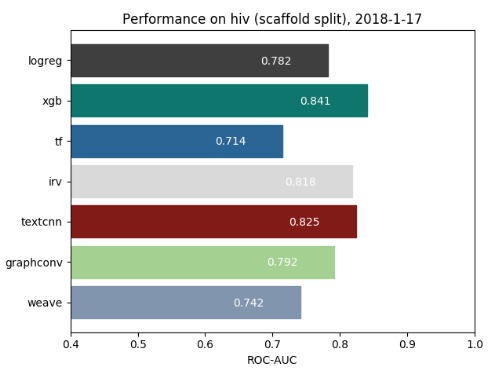

Source: https://moleculenet.org/latest-results

### SMILES representation and important sidenodes

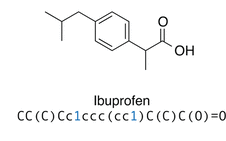
 
 Source: https://medium.com/@sunitachoudhary103/generating-molecules-using-a-char-rnn-in-pytorch-16885fd9394b

- Using the plain SMILES string as input is not suitable
- This will not consider the molecule structure but rather the grammar of the SMILES string
- The SMILES string can be different for a molecule, depending on the notation ( a unique molecule can have multiple SMILES strings )
- Chemical graphs however, are invariant to permutations --> Graph Neural Networks


## Looking into the Dataframe

In [7]:
#Creating folder "data" and subfolder "raw" to store HIV.csv file
import os
path = '/content/data/raw'
try:
  os.makedirs(path)
except OSError as e:
  print(e)

[Errno 17] File exists: '/content/data/raw'


In [8]:
#Creating subfolder images to store confusion matrix image
path1 = '/content/data/images'
try:
  os.makedirs(path1)
except OSError as e:
  print(e)

[Errno 17] File exists: '/content/data/images'


In [9]:
#Loading Dataframe
import pandas as pd
data_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv"
data= pd.read_csv(data_url) #function to read csv file 
import requests

#Writing the csv file to our local directory
response = requests.get(data_url)
open("/content/data/raw/HIV.csv", "wb").write(response.content)
#data_path = "/content/HIV_train_oversampled.csv"
#data = pd.read_csv(data_path)
data.head() #displaying the results
display(data)

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


#Oversampling our dataset

In [10]:
#General information about dataset
print(data.shape)
#(Number of Rows, Number of features of each molecule)
print(data["HIV_active"].value_counts())
# Prints the number of HIV active and inactive molecules

(41127, 3)
0    39684
1     1443
Name: HIV_active, dtype: int64


* Contains 41127 molecules and 4 features - Index, Molecules(smiles), activity and hiv_active
* 1443 are hiv inhibitors

**Need for Oversampling:** 

As we observe that our data is highly imbalanced as it contains about 41,127 molecules and only 1443 are HIV inhibitors, thus we need to consider this imbalance when evaluating performance of algorithm. We could also just resolve it by oversampling the minority class.

Imbalanced datasets are those where there is a severe skew in the class distribution, such as 1:100 or 1:1000 examples in the minority class to the majority class.

This bias in the training dataset can influence many machine learning algorithms, leading some to ignore the minority class entirely. This is a problem as it is typically the minority class on which predictions are most important.

One approach to addressing the problem of class imbalance is to randomly resample the training dataset.


> **Oversampling**
* Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
* Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.
* Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/



In [12]:
# Load raw dataset
import pandas as pd

data = pd.read_csv("data/raw/HIV_train.csv")
data.index = data["index"]
data["HIV_active"].value_counts()
start_index = data.iloc[0]["index"]

# Apply oversampling

# Check how many additional samples we need
neg_class = data["HIV_active"].value_counts()[0]
pos_class = data["HIV_active"].value_counts()[1]
multiplier = int(neg_class/pos_class) - 1

# Replicate the dataset for the positive class
replicated_pos = [data[data["HIV_active"] == 1]]*multiplier

# Append replicated data
data = data.append(replicated_pos,
                    ignore_index=True)
print(data.shape[0])
#Print number of molecules after oversampling

# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

# Re-assign index (This is our ID later)
index = range(start_index, start_index + data.shape[0])
data.index = index
data["index"] = data.index
data.head()

# Saving our oversampled csv file
data.to_csv("data/raw/HIV_train_oversampled.csv")

<ipython-input-12-33f2497181ce>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(replicated_pos,


71634


In [13]:
#Checking if data is oversampled
print(data["HIV_active"].value_counts())

0    35850
1    35784
Name: HIV_active, dtype: int64


After oversampling, We have 71634 molecules out of which 35784 are hiv inhibitors.

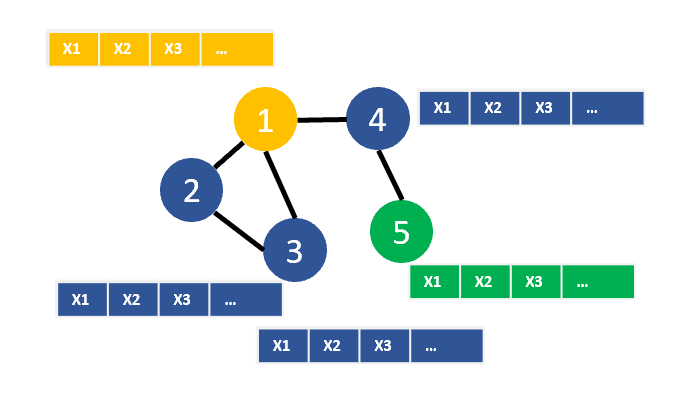

#Converting SMILES to RDKit molecules - Visualizing molecules

We want to convert smiles molecules to graphs.

Sources-
* https://www.rdkit.org/docs/Install.html#
* https://iwatobipen.wordpress.com/2018/11/01/run-rdkit-and-deep-learning-on-google-colab-rdkit/
* https://colab.research.google.com/drive/1gBkrpxFAH-Fmn8QtThRUYKlCU52DiUXn?usp=sharing#scrollTo=ZBusQXn3inSy

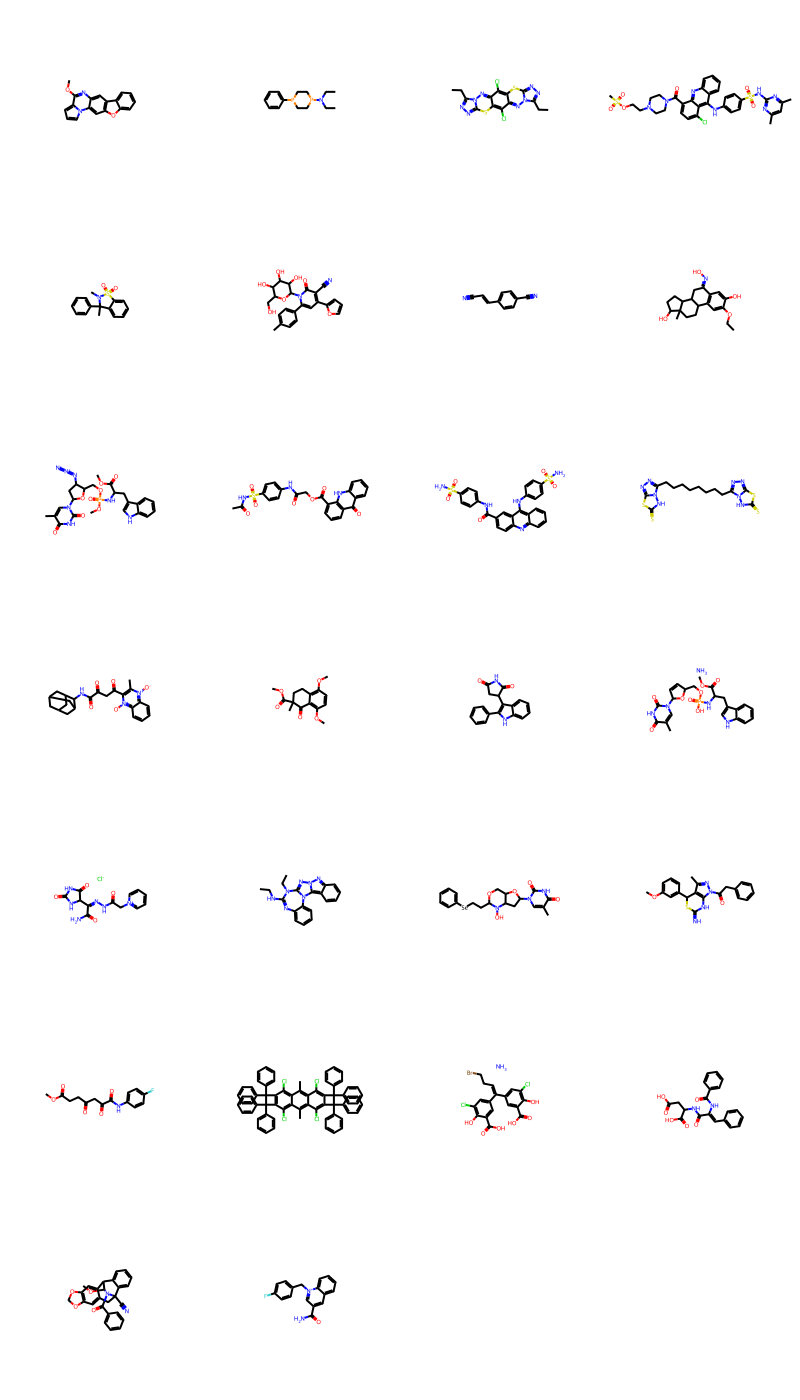

In [35]:
# Show sample molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw


#Converts smiles string to molecular objects


sample_smiles = data["smiles"][4:30].values
sample_mols = [Chem.MolFromSmiles(smiles) for \
               smiles in sample_smiles]
#Selecting a small subset of smile values and coverting to molecule objects

#Displaying molecules in grid
grid = Draw.MolsToGridImage(sample_mols, 
                      molsPerRow = 4,
                      subImgSize = (200,200) )
display(grid)


- We can also obtain the features from this RDKit representation
- It tells us everything we need to know e.g. atom features (type, ...), edges, ... 
- **In our case however, It's even easier as we have the information explicitly given already in the dataset**
- Otherwise we would calculate the node features from those atom properties

-> For datasets containing SMILES representations this would be the way to go

#Dataset_featurizer: Building our custom dataset using Pytorch Geometric

In the following we will perform predictions based on the graph level. This means we have one y-label for the whole graph, as shown on the left image below. The right image would be node-level-predictions.

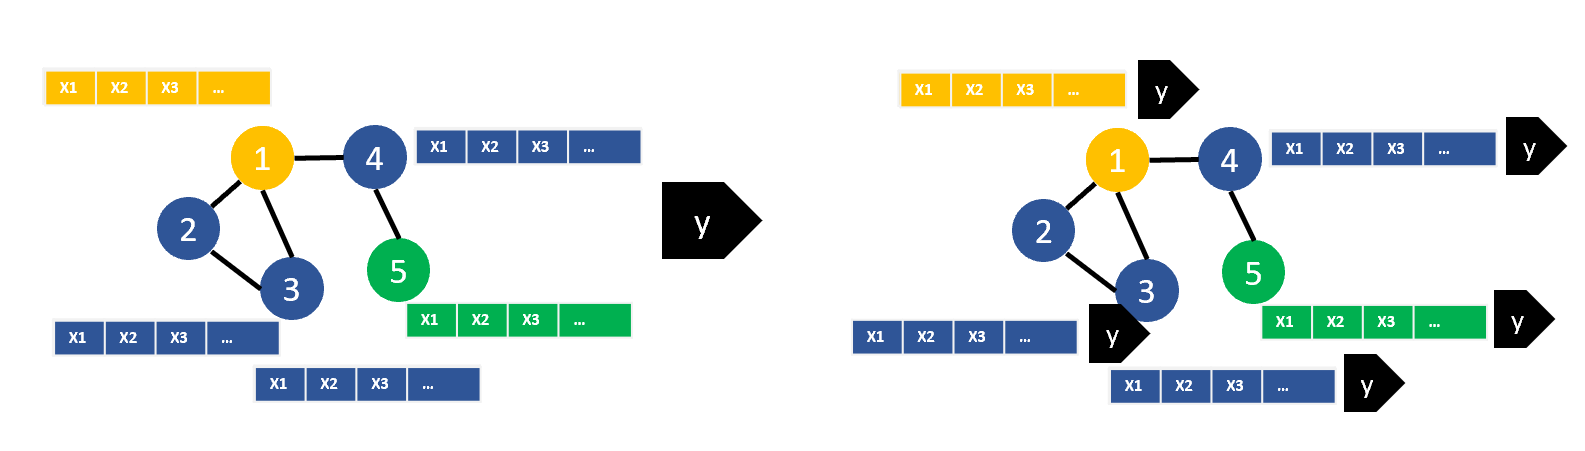

Source: https://colab.research.google.com/drive/16GBgwYR2ECiXVxA1BoLxYshKczNMeEAQ?usp=sharing#scrollTo=t2aqwJJ_bUC_



**Creating our own dataset** - Create node and edge features from molecule descriptions



In [23]:
import pandas as pd
from rdkit import Chem
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm
#tqdm - Adds progress bar

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

"""
!!!
NOTE: This file was replaced by dataset_featurizer.py
but is kept to illustrate how to build a custom dataset in PyG.
!!!
"""

#Calculate all features and labels for every molecule
class MoleculeDataset(Dataset):

    #pass the root directory where dataset is stored containing subfolders raw and processed
    #pass in root -> data filled in process dir
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self): #contained raw files
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    #If data already in process directory, it will not trigger any process
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            #Pass node features in data_obj as x
            #Calculate all features and labels for every molecule
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []
        #Appending all these features to our all_node_feats array
        #iterate over each atom in a molecule
        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix - list of lists
            #No. of nodes x feature size
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []
        #Appending all these features in all_edge_feats
        #Iterate over all bonds
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        #Indicates graph connectivities
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        
        edge_indices = []
        #Graph connectivities in coo format
        #add the edge features twice for each bond (once for each direction)
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    #LABEL - 0 OR 1
    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    #store data set in the processed folder creating in data folder
    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data




Torch version: 2.0.0+cu118
Cuda available: True
Torch geometric version: 2.3.1


In [25]:
 # Testing the dataset
dataset = MoleculeDataset(root = '/content/data',filename="HIV.csv")

Processing...
 85%|████████▌ | 35138/41127 [01:02<00:08, 744.31it/s][03:54:40] WARNING: not removing hydrogen atom without neighbors
[03:54:40] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41127/41127 [01:11<00:00, 575.86it/s]
Done!


Accessing data at specific index

In [26]:
print(dataset[0].edge_index.t())
#Obtaining edge index in coo format
print(dataset[0].x)
#Node feature matrix
print(dataset[0].edge_attr)
#Edge Features
print(dataset[0].y)
#Labels

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 6,  9],
        [ 9,  6],
        [ 4, 10],
        [10,  4],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [11, 14],
        [14, 11],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [15, 18],
        [18, 15],
        [ 9,  2],
        [ 2,  9],
        [18,  4],
        [ 4, 18]])
tensor([[ 6.,  1.,  0.,  4.,  0.,  3.,  0.,  0.,  0.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  1.,  0.],
        [ 8.,  2.,  1.,  3.,  0.,  0.,  0.,  1.,  0.],
        [29.,  4., -3.,  0.,  0.,  0.,  0.,  1.,  0.],
    

#Using deepchem Featurizer : MolGraphConvFeaturizer

Source: https://github.com/deepchem/deepchem, https://github.com/deepchem/deepchem#installation,

https://github.com/deepchem/deepchem/tree/master/examples

Deepchem library consists of several featurizers -


> [MolGraphConvFeaturizer](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#molgraphconvfeaturizer) : This class is a featurizer of general graph convolution networks for molecules.
- based on WeaveNet paper

The default node representation are constructed by concatenating the following values, and the feature length is 30.

- Atom type: A one-hot vector of this atom, “C”, “N”, “O”, “F”, “P”, “S”, “Cl”, “Br”, “I”, “other atoms”.

- Formal charge: Integer electronic charge.

- Hybridization: A one-hot vector of “sp”, “sp2”, “sp3”.

- Hydrogen bonding: A one-hot vector of whether this atom is a hydrogen bond donor or acceptor.

- Aromatic: A one-hot vector of whether the atom belongs to an aromatic ring.

- Degree: A one-hot vector of the degree (0-5) of this atom.

- Number of Hydrogens: A one-hot vector of the number of hydrogens (0-4) that this atom connected.

- Chirality: A one-hot vector of the chirality, “R” or “S”. (Optional)

- Partial charge: Calculated partial charge. (Optional)

The default edge representation are constructed by concatenating the following values, and the feature length is 11.

- Bond type: A one-hot vector of the bond type, “single”, “double”, “triple”, or “aromatic”.

- Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.

- Conjugated: A one-hot vector of whether this bond is conjugated or not.

- Stereo: A one-hot vector of the stereo configuration of a bond.



In [24]:
#Code for Deepchem featurizer

#Building our Graph Neural Network for classification

Source: https://colab.research.google.com/drive/16GBgwYR2ECiXVxA1BoLxYshKczNMeEAQ?usp=sharing#scrollTo=BQnbktyWU3r3

##Graph - Level predictions

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

The model learns to classify graphs using three main steps:



1.   Embed nodes using several rounds of message passing.
2.   Aggregate these node embeddings into a single graph embedding (called readout layer). The average of node embeddings can be used (global mean pool). The max of node embeddings can be used (global max pool) or we can concatenate of both.
3.Train a classifier based on graph embeddings.

source: https://blog.dataiku.com/graph-neural-networks-part-three#:~:text=Model%20Architecture,used%20(global%20mean%20pool).

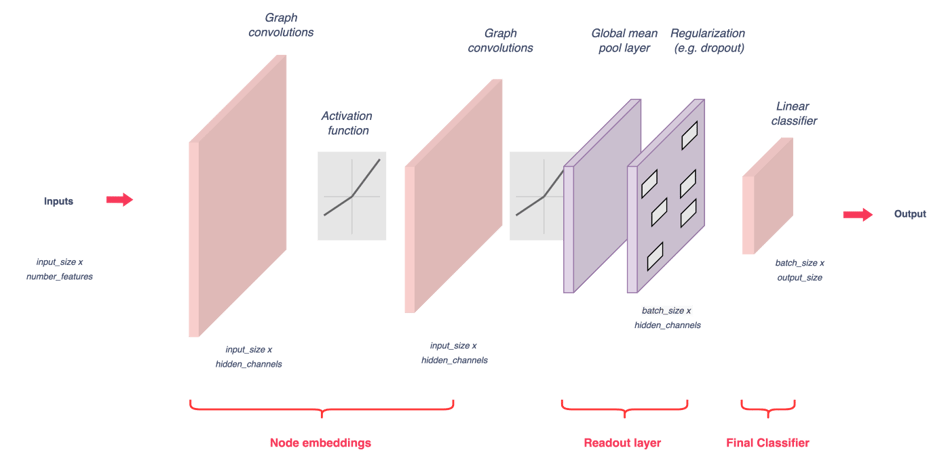

Our model has following layer :



*  graph Transformer convolution layers -  

GCNs perform similar operations where the model learns the features by inspecting neighboring nodes. The major difference between CNNs and GNNs is that CNNs are specially built to operate on regular (Euclidean) structured data, while GNNs are the generalized version of CNNs where the numbers of nodes connections vary and the nodes are unordered (irregular on non-Euclidean structured data).


*  top k pooling layers (as the molecule are not too big , three layers should be sufficient)

we used n attention heads and multiple of n in next layer to get original embedded size





In [27]:
#We use intermediate results of node embeddings and include in final result

import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling
# TopKPooling: simply drops specific nodes to reduce the size of the graph the joints 
# which nodes to drop depends on a learnable vector that squeezes each of the full
# embeddings into one dimension based on the values of this vector the top k nodes 
# are selected and used to build a new graph


from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        embedding_size = model_params["model_embedding_size"]
        n_heads = model_params["model_attention_heads"]
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        top_k_ratio = model_params["model_top_k_ratio"]
        self.top_k_every_n = model_params["model_top_k_every_n"]
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size, 
                                    embedding_size, 
                                    heads=n_heads, 
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size, 
                                                    embedding_size, 
                                                    heads=n_heads, 
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))
            #The graph transformer operator from the `"Masked Label Prediction:
            # Unified Message Passing Model for Semi-Supervised Classification
            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            #Applies a linear transformation to the incoming data y=A'x+b
            #source-pytorch docs
            self.bn_layers.append(BatchNorm1d(embedding_size))
            #Applies Batch Normalization over a 2D or 3D input as described in
            # the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))
            

        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))  
        self.linear3 = Linear(int(dense_neurons/2), 1)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
    
        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x

In [28]:
! pip install mlflow --quiet

**torch_geometric** References:
* https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
* https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html
* https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch-geometric-nn

In [36]:
#%% imports 
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import mlflow.pytorch
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Specify tracking server
mlflow.set_tracking_uri("http://localhost:5000")



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step

def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    # Enumerate over the data
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(torch.squeeze(pred), batch.y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step

def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true)
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    cfm_plot.figure.savefig(f'data/images/cm_{epoch}.png')
    mlflow.log_artifact(f"data/images/cm_{epoch}.png")

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    mlflow.log_metric(key=f"Precision-{type}", value=float(prec), step=epoch)
    mlflow.log_metric(key=f"Recall-{type}", value=float(rec), step=epoch)
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")



In [37]:
#Required for our alternate method
!pip install mlflow --quiet
import mlflow
!pip install pyngrok --quiet
from pyngrok import ngrok

# MLflow + Colab

References used for MLFlow:

* https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab
* https://medium.com/the-point-collections/intro-to-mlflow-with-colab-part-1-2-beb80c960ad9
* https://colab.research.google.com/drive/1BkNQpu1H3r-1ejNIaX4-fc2eNyBcGkEC?usp=sharing#scrollTo=LdSp3WikkbFk
* https://docs.databricks.com/mlflow/index.html

MLflow is a tracking tool. It helps you track the hyper-parameters, metrics and so much more.

We Log experiments with Google Colab, directly to an MLflow remote.

It uses DAGsHub MLflow remote server, which is a free hosted MLflow remote.

Instructions:
1. [Sign up to DAGsHub](https://dagshub.com/user/sign_up)
1. [Create an access token](https://dagshub.com/user/settings/tokens)
1. [Create a new project](https://dagshub.com/repo/create)
1. [Open the notebook in Google Colab](https://dagshub.com/Dean/mlflow-colab-example/src/master/mlflow-colab.ipynb)
1. Run the cell
1. Fill in your DAGsHub username, access token and project name.
1. Run the visualization cell if you want to see your experiments inside Colab.

*Note: All the login credentials are given in comments just below*

See the results on: https://dagshub.com/sanketpotdar.iitb/EE769_Project

In [38]:
!pip install mlflow dagshub --quiet
import dagshub
import mlflow

from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
#sanketpotdar.iitb
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
#2671f902c3b2050370b3b48a6301823d0585d4be
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')
#EE769_Project
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] 
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

Enter your DAGsHub username: sanketpotdar.iitb
Enter your DAGsHub access token: ··········
Enter your DAGsHub project name: EE769_Project


In [39]:
!pip install arm-mango --quiet

We use **ARM-Mango** python library to find the optimal hyperparameters for machine learning classifiers. Mango enables parallel optimization over complex search spaces of continuous/discrete/categorical values.

- gradient-free optimizer 

References used:

- https://community.arm.com/arm-research/b/articles/posts/scalable-hyperparameter-tuning-for-automl
- https://github.com/ARM-software/mango/blob/main/README.md
- https://pypi.org/project/python-mango/

In [40]:
# %% Run the training

from mango import scheduler
#objective function can be scheduled to run locally or on a cluster with parallel evaluations
from mango import Tuner


def run_one_training(params):
    params = params[0]
    with mlflow.start_run(run_name="MLflow on Colab") as run:
        # Log parameters used in this experiment
        for key in params.keys():
            mlflow.log_param(key, params[key])

        # Loading the dataset
        print("Loading dataset...")
        train_dataset = MoleculeDataset(root="data/", filename="HIV_train_oversampled.csv")
        test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)
        params["model_edge_dim"] = train_dataset[0].edge_attr.shape[1]

        # Prepare training
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True)

        # Loading the model
        print("Loading model...")
        model_params = {k: v for k, v in params.items() if k.startswith("model_")}
        model = GNN(feature_size=train_dataset[0].x.shape[1], model_params=model_params) 
        model = model.to(device)
        print(f"Number of parameters: {count_parameters(model)}")
        mlflow.log_param("num_params", count_parameters(model))

        # < 1 increases precision, > 1 recall
        weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=params["learning_rate"],
                                    momentum=params["sgd_momentum"],
                                    weight_decay=params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
        
        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(80): 
            if early_stopping_counter <= 10: # = x * 5 
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                print(f"Epoch {epoch} | Train Loss {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Testing
                model.eval()
                if epoch % 5 == 0:
                    loss = test(epoch, model, test_loader, loss_fn)
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                    
                    # Update best loss
                    if float(loss) < best_loss:
                        best_loss = loss
                        # Save the currently best model 
                        mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                scheduler.step()
            else:
                print("Early stopping due to no improvement.")
                return [best_loss]

    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]


In [41]:
import numpy as np
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec


HYPERPARAMETERS = {
    "batch_size": [32, 128, 64],
    "learning_rate": [0.1, 0.05, 0.01, 0.001],
    "weight_decay": [0.0001, 0.00001, 0.001, 0.01, 0.1],
    "sgd_momentum": [0.9, 0.8, 0.7, 0.6, 0.5],
    "scheduler_gamma": [0.995, 0.9, 0.8, 0.7, 0.5, 1],
    "pos_weight" : [1.0, 1.1, 1.2, 1.3, 1.4],  
    "model_embedding_size": [8, 16, 32, 64, 128],
    "model_attention_heads": [1, 2, 3, 4],
    "model_layers": [3, 4, 5, 6],
    "model_dropout_rate": [0.1, 0.2, 0.3, 0.5, 0.9],
    "model_top_k_ratio": [0.2, 0.4, 0.5, 0.6, 0.8, 0.9],
    "model_top_k_every_n": [10e-10, 1, 2, 3],
    "model_dense_neurons": [16, 128, 64, 256, 32]
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 30), name="x"), 
                       TensorSpec(np.dtype(np.float32), (-1, 11), name="edge_attr"), 
                       TensorSpec(np.dtype(np.int32), (2, -1), name="edge_index"), 
                       TensorSpec(np.dtype(np.int32), (-1, 1), name="batch_index")])

output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1))])

SIGNATURE = ModelSignature(inputs=input_schema, outputs=output_schema)


Running hyperparameter search...
Loading dataset...
Loading model...
Number of parameters: 13465


100%|██████████| 1120/1120 [01:43<00:00, 10.86it/s]



 Confusion matrix: 
 [[ 3950  3866]
 [31900 31918]]
F1 Score: 0.6409108250838336
Accuracy: 0.5007119524248262
Precision: 0.5001410260428092
Recall: 0.8919628884417616
ROC AUC: 0.5010720997299464
Epoch 0 | Train Loss 0.7876794787389891
[[0.5333847 ]
 [0.5345226 ]
 [0.5358727 ]
 [0.52960825]
 [0.53426737]
 [0.5333341 ]
 [0.52843887]
 [0.52821267]
 [0.5342992 ]
 [0.5337174 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 1 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[   0    0]
 [3834  165]]
F1 Score: 0.0792507204610951
Accuracy: 0.04126031507876969
Precision: 0.04126031507876969
Recall: 1.0
ROC AUC: 0.5


2023/04/30 04:50:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 0 | Test Loss 0.7811069062777928


2023/04/30 04:50:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
100%|██████████| 1120/1120 [01:55<00:00,  9.71it/s]



 Confusion matrix: 
 [[  415   402]
 [35435 35382]]
F1 Score: 0.6638211649046444
Accuracy: 0.4997208029706564
Precision: 0.4996257960659164
Recall: 0.988765928906774
ROC AUC: 0.5001709700321875
Epoch 1 | Train Loss 0.7645678197698934


100%|██████████| 1120/1120 [01:29<00:00, 12.49it/s]



 Confusion matrix: 
 [[ 4725  2990]
 [31125 32794]]
F1 Score: 0.6578337662858691
Accuracy: 0.5237596671971411
Precision: 0.5130555859760009
Recall: 0.9164431030628214
ROC AUC: 0.5241211331213689
Epoch 2 | Train Loss 0.7541906541479485


100%|██████████| 1120/1120 [01:27<00:00, 12.81it/s]



 Confusion matrix: 
 [[11621  6896]
 [24229 28888]]
F1 Score: 0.6498914522896256
Accuracy: 0.5654996230840104
Precision: 0.5438560159647571
Recall: 0.8072881734853565
ROC AUC: 0.5657221899504885
Epoch 3 | Train Loss 0.7484786156032767


100%|██████████| 1120/1120 [01:32<00:00, 12.16it/s]



 Confusion matrix: 
 [[16143  9355]
 [19707 26429]]
F1 Score: 0.6452392578125
Accuracy: 0.5942987966608035
Precision: 0.5728498352696376
Recall: 0.7385703107534094
ROC AUC: 0.5944315988913491
Epoch 4 | Train Loss 0.7465045824114765


100%|██████████| 1120/1120 [01:26<00:00, 12.94it/s]



 Confusion matrix: 
 [[17397  9954]
 [18453 25830]]
F1 Score: 0.645209636929072
Accuracy: 0.6034424993718067
Precision: 0.5832938147821963
Recall: 0.721830985915493
ROC AUC: 0.6035514762213448
Epoch 5 | Train Loss 0.7449993884457009
[[0.47273207]
 [0.49737287]
 [0.47348538]
 [0.5109083 ]
 [0.47229293]
 [0.47500235]
 [0.47434235]
 [0.49401104]
 [0.5448732 ]
 [0.49415073]]
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[0 0 0 0 0 0 0 0 0 1]

 Confusion matrix: 
 [[2758   53]
 [1076  112]]
F1 Score: 0.1655580192165558
Accuracy: 0.7176794198549638
Precision: 0.09427609427609428
Recall: 0.6787878787878788
ROC AUC: 0.6990705173803765


2023/04/30 04:58:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 5 | Test Loss 0.7017452281618876


2023/04/30 04:58:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
100%|██████████| 1120/1120 [01:37<00:00, 11.52it/s]



 Confusion matrix: 
 [[18847 10798]
 [17003 24986]]
F1 Score: 0.6425366129633678
Accuracy: 0.611902169360918
Precision: 0.5950606111124342
Recall: 0.6982450257098144
ROC AUC: 0.6119816481408207
Epoch 6 | Train Loss 0.7432496203375715


100%|██████████| 1120/1120 [01:30<00:00, 12.44it/s]



 Confusion matrix: 
 [[19407 11005]
 [16443 24779]]
F1 Score: 0.6435602420590603
Accuracy: 0.6168299969288327
Precision: 0.6011110572024647
Recall: 0.6924603174603174
ROC AUC: 0.6168996147971043
Epoch 7 | Train Loss 0.742014915389674


100%|██████████| 1120/1120 [01:25<00:00, 13.06it/s]



 Confusion matrix: 
 [[20015 11468]
 [15835 24316]]
F1 Score: 0.6404424837031671
Accuracy: 0.6188541753915738
Precision: 0.6056138078752709
Recall: 0.6795215738877711
ROC AUC: 0.6189100198588089
Epoch 8 | Train Loss 0.7408002693206072


100%|██████████| 1120/1120 [01:29<00:00, 12.50it/s]



 Confusion matrix: 
 [[19913 11360]
 [15937 24424]]
F1 Score: 0.6415129030139864
Accuracy: 0.6189379345003769
Precision: 0.6051386239191299
Recall: 0.6825396825396826
ROC AUC: 0.6189964800425052
Epoch 9 | Train Loss 0.7396561163344554


100%|██████████| 1120/1120 [01:26<00:00, 13.02it/s]



 Confusion matrix: 
 [[19996 11270]
 [15854 24514]]
F1 Score: 0.6438176279020906
Accuracy: 0.6213529888041991
Precision: 0.6072631787554499
Recall: 0.685054773082942
ROC AUC: 0.621411626429895
Epoch 10 | Train Loss 0.7406464260071516
[[0.46869653]
 [0.487786  ]
 [0.5108826 ]
 [0.7108445 ]
 [0.4692895 ]
 [0.46816012]
 [0.46758857]
 [0.56301886]
 [0.48208663]
 [0.47287762]]
[0. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2681   50]
 [1153  115]]
F1 Score: 0.16050244242847175
Accuracy: 0.6991747936984246
Precision: 0.09069400630914827
Recall: 0.696969696969697
ROC AUC: 0.6981196945985678
Epoch 10 | Test Loss 0.7138262419473558


100%|██████████| 1120/1120 [01:28<00:00, 12.69it/s]



 Confusion matrix: 
 [[20387 11718]
 [15463 24066]]
F1 Score: 0.6390928524955852
Accuracy: 0.6205572772705699
Precision: 0.6088188418629361
Recall: 0.6725352112676056
ROC AUC: 0.6206051230675544
Epoch 11 | Train Loss 0.7404119340968983


100%|██████████| 1120/1120 [01:27<00:00, 12.77it/s]



 Confusion matrix: 
 [[20446 11547]
 [15404 24237]]
F1 Score: 0.6426781571097117
Accuracy: 0.6237680431080214
Precision: 0.6114124265280896
Recall: 0.6773138832997988
ROC AUC: 0.6238173321659385
Epoch 12 | Train Loss 0.7396100026156222


100%|██████████| 1120/1120 [01:28<00:00, 12.62it/s]



 Confusion matrix: 
 [[20239 11367]
 [15611 24417]]
F1 Score: 0.6441460454809266
Accuracy: 0.6233911271184075
Precision: 0.6099980013990207
Recall: 0.6823440643863179
ROC AUC: 0.6234453934204951
Epoch 13 | Train Loss 0.737894455237048


100%|██████████| 1120/1120 [01:22<00:00, 13.59it/s]



 Confusion matrix: 
 [[20002 11295]
 [15848 24489]]
F1 Score: 0.6434229713219742
Accuracy: 0.6210877516263227
Precision: 0.6071100974291593
Recall: 0.6843561368209256
ROC AUC: 0.621145990307255
Epoch 14 | Train Loss 0.738137344324163


100%|██████████| 1120/1120 [01:24<00:00, 13.22it/s]



 Confusion matrix: 
 [[19953 11229]
 [15897 24555]]
F1 Score: 0.6441838501495356
Accuracy: 0.6213250691012647
Precision: 0.6070157223375853
Recall: 0.6862005365526492
ROC AUC: 0.6213847871047764
Epoch 15 | Train Loss 0.7379802346761738
[[0.4691277 ]
 [0.7064923 ]
 [0.46682698]
 [0.5253705 ]
 [0.55085087]
 [0.4744166 ]
 [0.46753004]
 [0.6949342 ]
 [0.53873384]
 [0.4668497 ]]
[0. 1. 0. 1. 1. 0. 0. 1. 1. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2734   52]
 [1100  113]]
F1 Score: 0.16400580551523947
Accuracy: 0.7119279819954989
Precision: 0.09315746084089035
Recall: 0.6848484848484848
ROC AUC: 0.6989709299568454


2023/04/30 05:13:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 15 | Test Loss 0.701639990011851


2023/04/30 05:13:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
100%|██████████| 1120/1120 [01:22<00:00, 13.51it/s]



 Confusion matrix: 
 [[19909 11218]
 [15941 24566]]
F1 Score: 0.6440078121927882
Accuracy: 0.6208643940028478
Precision: 0.60646308045523
Recall: 0.6865079365079365
ROC AUC: 0.6209248190210533
Epoch 16 | Train Loss 0.7395260166376829


100%|██████████| 1120/1120 [01:24<00:00, 13.27it/s]



 Confusion matrix: 
 [[19863 11245]
 [15987 24539]]
F1 Score: 0.6431398244004718
Accuracy: 0.6198453248457436
Precision: 0.6055125104870948
Recall: 0.6857534093449587
ROC AUC: 0.6199059933754082
Epoch 17 | Train Loss 0.7402918080666235


100%|██████████| 1120/1120 [01:24<00:00, 13.31it/s]



 Confusion matrix: 
 [[19886 11201]
 [15964 24583]]
F1 Score: 0.644115758997
Accuracy: 0.6207806348940448
Precision: 0.6062840654055787
Recall: 0.6869830091661078
ROC AUC: 0.6208415743180609
Epoch 18 | Train Loss 0.7377197677003485


100%|██████████| 1120/1120 [01:30<00:00, 12.39it/s]



 Confusion matrix: 
 [[19876 11168]
 [15974 24616]]
F1 Score: 0.6446172781313012
Accuracy: 0.6211017114777899
Precision: 0.6064547918206454
Recall: 0.6879052090319696
ROC AUC: 0.6211632042370449
Epoch 19 | Train Loss 0.7379203427050794


100%|██████████| 1120/1120 [01:23<00:00, 13.42it/s]



 Confusion matrix: 
 [[20004 11284]
 [15846 24500]]
F1 Score: 0.6436358859845002
Accuracy: 0.621269229695396
Precision: 0.6072473107619095
Recall: 0.6846635367762128
ROC AUC: 0.621327584287688
Epoch 20 | Train Loss 0.7383595878524439
[[0.6102828 ]
 [0.4667582 ]
 [0.4652342 ]
 [0.4661239 ]
 [0.66405284]
 [0.4665805 ]
 [0.46873006]
 [0.6459625 ]
 [0.46714896]
 [0.46885625]]
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
[1 0 0 0 1 0 0 1 0 0]

 Confusion matrix: 
 [[2794   52]
 [1040  113]]
F1 Score: 0.17147192716236723
Accuracy: 0.7269317329332333
Precision: 0.09800520381613183
Recall: 0.6848484848484848
ROC AUC: 0.7067956560914307


2023/04/30 05:20:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 20 | Test Loss 0.6973706398691449


2023/04/30 05:20:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
100%|██████████| 1120/1120 [01:23<00:00, 13.46it/s]



 Confusion matrix: 
 [[19885 11106]
 [15965 24678]]
F1 Score: 0.6457927172334386
Accuracy: 0.6220928609319597
Precision: 0.6071894299141304
Recall: 0.6896378269617707
ROC AUC: 0.6221550362144976
Epoch 21 | Train Loss 0.7375793545373849


100%|██████████| 1120/1120 [01:28<00:00, 12.63it/s]



 Confusion matrix: 
 [[19859 11241]
 [15991 24543]]
F1 Score: 0.6431772321077596
Accuracy: 0.6198453248457436
Precision: 0.6054916859920068
Recall: 0.6858651911468813
ROC AUC: 0.6199060962707906
Epoch 22 | Train Loss 0.7390482848244054


100%|██████████| 1120/1120 [01:27<00:00, 12.86it/s]



 Confusion matrix: 
 [[19888 11271]
 [15962 24513]]
F1 Score: 0.6428880525577308
Accuracy: 0.6198313649942765
Precision: 0.605633106856084
Recall: 0.6850268276324615
ROC AUC: 0.6198913775540271
Epoch 23 | Train Loss 0.7388959258262601


100%|██████████| 1120/1120 [01:27<00:00, 12.82it/s]



 Confusion matrix: 
 [[19983 11171]
 [15867 24613]]
F1 Score: 0.6454683730200356
Accuracy: 0.6225535360303767
Precision: 0.6080286561264822
Recall: 0.6878213726805276
ROC AUC: 0.6226136152105567
Epoch 24 | Train Loss 0.7392154502549342


100%|██████████| 1120/1120 [01:26<00:00, 12.97it/s]



 Confusion matrix: 
 [[19833 11302]
 [16017 24482]]
F1 Score: 0.6418730254447256
Accuracy: 0.6186308177680989
Precision: 0.6045087533025507
Recall: 0.6841605186675609
ROC AUC: 0.6186911379948683
Epoch 25 | Train Loss 0.7384084383291858
[[0.48654637]
 [0.46629095]
 [0.48053345]
 [0.6571172 ]
 [0.4733675 ]
 [0.46810487]
 [0.5451018 ]
 [0.4708582 ]
 [0.47869894]
 [0.64644474]]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2737   52]
 [1097  113]]
F1 Score: 0.16436363636363638
Accuracy: 0.7126781695423856
Precision: 0.09338842975206611
Recall: 0.6848484848484848
ROC AUC: 0.6993621662635747
Epoch 25 | Test Loss 0.6998128881530156


100%|██████████| 1120/1120 [01:28<00:00, 12.69it/s]



 Confusion matrix: 
 [[20054 11238]
 [15796 24546]]
F1 Score: 0.6448782282006148
Accuracy: 0.6226093754362454
Precision: 0.6084477715532199
Recall: 0.6859490274983233
ROC AUC: 0.6226676797184783
Epoch 26 | Train Loss 0.7382714623319251


100%|██████████| 1120/1120 [01:25<00:00, 13.05it/s]



 Confusion matrix: 
 [[19870 11140]
 [15980 24644]]
F1 Score: 0.6450633441524447
Accuracy: 0.6214088282100678
Precision: 0.6066364710515951
Recall: 0.6886876816454282
ROC AUC: 0.6214707585354058
Epoch 27 | Train Loss 0.7392937599016087


100%|██████████| 1120/1120 [01:29<00:00, 12.53it/s]



 Confusion matrix: 
 [[19836 11157]
 [16014 24627]]
F1 Score: 0.6444749754661433
Accuracy: 0.6206968757852417
Precision: 0.6059644201668266
Recall: 0.6882126089872569
ROC AUC: 0.6207590241589004
Epoch 28 | Train Loss 0.7388788490955319


100%|██████████| 1120/1120 [01:25<00:00, 13.11it/s]



 Confusion matrix: 
 [[19926 11121]
 [15924 24663]]
F1 Score: 0.6458734336331854
Accuracy: 0.6224558170701063
Precision: 0.6076576243624806
Recall: 0.6892186452045607
ROC AUC: 0.6225172723930754
Epoch 29 | Train Loss 0.7374128683337143


100%|██████████| 1120/1120 [01:28<00:00, 12.63it/s]



 Confusion matrix: 
 [[19918 11269]
 [15932 24515]]
F1 Score: 0.6431766604137424
Accuracy: 0.6202780802412262
Precision: 0.6061018122481272
Recall: 0.6850827185334227
ROC AUC: 0.6203377330463488
Epoch 30 | Train Loss 0.7386446480772325
[[0.6536764 ]
 [0.46665317]
 [0.46754774]
 [0.4771836 ]
 [0.51091325]
 [0.47070768]
 [0.6437869 ]
 [0.4820228 ]
 [0.46765828]
 [0.4672228 ]]
[1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2793   52]
 [1041  113]]
F1 Score: 0.17134192570128887
Accuracy: 0.7266816704176045
Precision: 0.09792027729636049
Recall: 0.6848484848484848
ROC AUC: 0.7066652439891876
Epoch 30 | Test Loss 0.7013257931149195


100%|██████████| 1120/1120 [01:26<00:00, 12.93it/s]



 Confusion matrix: 
 [[19920 11209]
 [15930 24575]]
F1 Score: 0.644260640459306
Accuracy: 0.6211435910321914
Precision: 0.6067152203431675
Recall: 0.6867594455622624
ROC AUC: 0.621203990563558
Epoch 31 | Train Loss 0.7389357752033643


100%|██████████| 1120/1120 [01:28<00:00, 12.71it/s]



 Confusion matrix: 
 [[19890 11149]
 [15960 24635]]
F1 Score: 0.6450725984891136
Accuracy: 0.6215623865762069
Precision: 0.606848134006651
Recall: 0.6884361725911021
ROC AUC: 0.6216239440361369
Epoch 32 | Train Loss 0.7387547840497324


100%|██████████| 1120/1120 [01:26<00:00, 12.94it/s]



 Confusion matrix: 
 [[19943 11105]
 [15907 24679]]
F1 Score: 0.6463009034961372
Accuracy: 0.6229164921685233
Precision: 0.6080668210713054
Recall: 0.6896657724122512
ROC AUC: 0.6229779350206305
Epoch 33 | Train Loss 0.7383447067013809


100%|██████████| 1120/1120 [01:29<00:00, 12.51it/s]



 Confusion matrix: 
 [[19760 11296]
 [16090 24488]]
F1 Score: 0.641366124512192
Accuracy: 0.6176955077197979
Precision: 0.6034797180738332
Recall: 0.6843281913704449
ROC AUC: 0.6177568432444972
Epoch 34 | Train Loss 0.739343155122229


100%|██████████| 1120/1120 [01:25<00:00, 13.13it/s]



 Confusion matrix: 
 [[19886 11241]
 [15964 24543]]
F1 Score: 0.6434048577158511
Accuracy: 0.6202222408353575
Precision: 0.6058952773594687
Recall: 0.6858651911468813
ROC AUC: 0.6202826653084476
Epoch 35 | Train Loss 0.7401831778564624
[[0.4664484 ]
 [0.507773  ]
 [0.4780756 ]
 [0.4672887 ]
 [0.46552542]
 [0.46697873]
 [0.4853622 ]
 [0.46628216]
 [0.46841875]
 [0.5193732 ]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2698   52]
 [1136  113]]
F1 Score: 0.15983026874115983
Accuracy: 0.7029257314328582
Precision: 0.09047237790232186
Recall: 0.6848484848484848
ROC AUC: 0.6942760942760944
Epoch 35 | Test Loss 0.7150497748738244


100%|██████████| 1120/1120 [01:28<00:00, 12.62it/s]



 Confusion matrix: 
 [[19870 11232]
 [15980 24552]]
F1 Score: 0.643429949158761
Accuracy: 0.6201245218750873
Precision: 0.6057436099871706
Recall: 0.6861167002012073
ROC AUC: 0.6201852678132954
Epoch 36 | Train Loss 0.7379891202385936


100%|██████████| 1120/1120 [01:20<00:00, 13.85it/s]



 Confusion matrix: 
 [[19706 11167]
 [16144 24617]]
F1 Score: 0.6432033444379124
Accuracy: 0.6187424965798364
Precision: 0.6039351340742376
Recall: 0.6879331544824503
ROC AUC: 0.6188061867251861
Epoch 37 | Train Loss 0.7391951482743024


100%|██████████| 1120/1120 [01:27<00:00, 12.81it/s]



 Confusion matrix: 
 [[19852 11158]
 [15998 24626]]
F1 Score: 0.6445921892995498
Accuracy: 0.6209062735572494
Precision: 0.6061933832217409
Recall: 0.6881846635367762
ROC AUC: 0.6209682034559754
Epoch 38 | Train Loss 0.7375704737646239


100%|██████████| 1120/1120 [01:25<00:00, 13.09it/s]



 Confusion matrix: 
 [[19798 11283]
 [16052 24501]]
F1 Score: 0.6419167638235719
Accuracy: 0.6184074601446241
Precision: 0.6041723177076912
Recall: 0.6846914822266935
ROC AUC: 0.6184684747256202
Epoch 39 | Train Loss 0.7396592439817531


100%|██████████| 1120/1120 [01:29<00:00, 12.51it/s]



 Confusion matrix: 
 [[19918 11081]
 [15932 24703]]
F1 Score: 0.6465146102409087
Accuracy: 0.6229025323170562
Precision: 0.6079242032730405
Recall: 0.6903364632237872
ROC AUC: 0.622964605391531
Epoch 40 | Train Loss 0.7380895925951856
[[0.46632156]
 [0.6037451 ]
 [0.48586556]
 [0.47444496]
 [0.465426  ]
 [0.48207065]
 [0.4664207 ]
 [0.4671956 ]
 [0.48345447]
 [0.47987935]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2736   52]
 [1098  113]]
F1 Score: 0.16424418604651164
Accuracy: 0.7124281070267567
Precision: 0.09331131296449216
Recall: 0.6848484848484848
ROC AUC: 0.6992317541613317
Epoch 40 | Test Loss 0.7023264973882645


100%|██████████| 1120/1120 [01:25<00:00, 13.13it/s]



 Confusion matrix: 
 [[19842 11164]
 [16008 24620]]
F1 Score: 0.6444014029210071
Accuracy: 0.6206829159337744
Precision: 0.605986019493945
Recall: 0.6880169908338922
ROC AUC: 0.6207448970905862
Epoch 41 | Train Loss 0.7390368895871299


100%|██████████| 1120/1120 [01:25<00:00, 13.15it/s]



 Confusion matrix: 
 [[19870 11216]
 [15980 24568]]
F1 Score: 0.643714300686475
Accuracy: 0.6203478794985622
Precision: 0.6058991812173227
Recall: 0.6865638274088979
ROC AUC: 0.6204088314171408
Epoch 42 | Train Loss 0.7382365022919007


100%|██████████| 1120/1120 [01:25<00:00, 13.03it/s]



 Confusion matrix: 
 [[19739 11158]
 [16111 24626]]
F1 Score: 0.6436403078893375
Accuracy: 0.6193288103414579
Precision: 0.6045118688170459
Recall: 0.6881846635367762
ROC AUC: 0.6193921922983742
Epoch 43 | Train Loss 0.7387248524065528


100%|██████████| 1120/1120 [01:24<00:00, 13.24it/s]



 Confusion matrix: 
 [[19721 11125]
 [16129 24659]]
F1 Score: 0.6440735516899128
Accuracy: 0.6195382081134657
Precision: 0.6045650681573012
Recall: 0.689106863402638
ROC AUC: 0.6196022462062005
Epoch 44 | Train Loss 0.7379053021115917


100%|██████████| 1120/1120 [01:22<00:00, 13.56it/s]



 Confusion matrix: 
 [[19843 11229]
 [16007 24555]]
F1 Score: 0.6432557042936106
Accuracy: 0.6197894854398749
Precision: 0.6053695577141167
Recall: 0.6862005365526492
ROC AUC: 0.6198506169513596
Epoch 45 | Train Loss 0.7391900495759078
[[0.4670042 ]
 [0.46655384]
 [0.4996488 ]
 [0.5542382 ]
 [0.4679593 ]
 [0.5981443 ]
 [0.4693317 ]
 [0.46876532]
 [0.5569585 ]
 [0.57449025]]
[0. 0. 0. 1. 0. 1. 0. 0. 1. 1.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2770   52]
 [1064  113]]
F1 Score: 0.16840536512667661
Accuracy: 0.7209302325581395
Precision: 0.09600679694137638
Recall: 0.6848484848484848
ROC AUC: 0.7036657656375966
Epoch 45 | Test Loss 0.701661729623401


100%|██████████| 1120/1120 [01:23<00:00, 13.39it/s]



 Confusion matrix: 
 [[19849 11142]
 [16001 24642]]
F1 Score: 0.6448506417888966
Accuracy: 0.6210877516263227
Precision: 0.6063036685284059
Recall: 0.6886317907444668
ROC AUC: 0.6211499260556365
Epoch 46 | Train Loss 0.7381932170263359


100%|██████████| 1120/1120 [01:21<00:00, 13.69it/s]



 Confusion matrix: 
 [[19824 11151]
 [16026 24633]]
F1 Score: 0.6444802009340294
Accuracy: 0.6206131166764386
Precision: 0.6058437246366118
Recall: 0.6883802816901409
ROC AUC: 0.6206754964936061
Epoch 47 | Train Loss 0.7375905742602689


100%|██████████| 1120/1120 [01:25<00:00, 13.06it/s]



 Confusion matrix: 
 [[19829 11203]
 [16021 24581]]
F1 Score: 0.6435996124944361
Accuracy: 0.6199570036574811
Precision: 0.6054135264272696
Recall: 0.6869271182651464
ROC AUC: 0.6200186497880823
Epoch 48 | Train Loss 0.739631120541266


100%|██████████| 1120/1120 [01:21<00:00, 13.75it/s]



 Confusion matrix: 
 [[19834 11141]
 [16016 24643]]
F1 Score: 0.64474183378465
Accuracy: 0.6208923137057821
Precision: 0.6060896726432032
Recall: 0.6886597361949475
ROC AUC: 0.6209546937599564
Epoch 49 | Train Loss 0.738486033092652


100%|██████████| 1120/1120 [01:24<00:00, 13.24it/s]



 Confusion matrix: 
 [[19823 11212]
 [16027 24572]]
F1 Score: 0.6433892358247254
Accuracy: 0.6197476058854734
Precision: 0.6052365821818272
Recall: 0.6866756092108205
ROC AUC: 0.6198092132525511
Epoch 50 | Train Loss 0.739803547039628
[[0.46994624]
 [0.47271317]
 [0.48070738]
 [0.5011884 ]
 [0.6943033 ]
 [0.46677262]
 [0.515462  ]
 [0.46809244]
 [0.4671483 ]
 [0.47866282]]
[0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2729   52]
 [1105  113]]
F1 Score: 0.16341287057122195
Accuracy: 0.7106776694173543
Precision: 0.09277504105090312
Recall: 0.6848484848484848
ROC AUC: 0.69831886944563
Epoch 50 | Test Loss 0.7063387168778313


100%|██████████| 1120/1120 [01:27<00:00, 12.86it/s]



 Confusion matrix: 
 [[19829 11175]
 [16021 24609]]
F1 Score: 0.6440966315073153
Accuracy: 0.6203478794985622
Precision: 0.6056854540979572
Recall: 0.687709590878605
ROC AUC: 0.6204098860948116
Epoch 51 | Train Loss 0.7393643129084791


100%|██████████| 1120/1120 [01:31<00:00, 12.30it/s]



 Confusion matrix: 
 [[19824 11169]
 [16026 24615]]
F1 Score: 0.6441609421000981
Accuracy: 0.6203618393500293
Precision: 0.6056691518417362
Recall: 0.6878772635814889
ROC AUC: 0.6204239874392801
Epoch 52 | Train Loss 0.7380643242704017


100%|██████████| 1120/1120 [01:30<00:00, 12.42it/s]



 Confusion matrix: 
 [[19837 11206]
 [16013 24578]]
F1 Score: 0.6436137479541735
Accuracy: 0.6200268029148169
Precision: 0.6055036830824567
Recall: 0.6868432819137045
ROC AUC: 0.6200883076235189
Epoch 53 | Train Loss 0.7385100914431469


100%|██████████| 1120/1120 [01:27<00:00, 12.77it/s]



 Confusion matrix: 
 [[19886 11166]
 [15964 24618]]
F1 Score: 0.6447371867061258
Accuracy: 0.621269229695396
Precision: 0.6066236262382337
Recall: 0.6879610999329309
ROC AUC: 0.6213306197014724
Epoch 54 | Train Loss 0.7388395745839391


100%|██████████| 1120/1120 [01:22<00:00, 13.50it/s]



 Confusion matrix: 
 [[19908 11245]
 [15942 24539]]
F1 Score: 0.6435193076771782
Accuracy: 0.6204735181617668
Precision: 0.6061856179442208
Recall: 0.6857534093449587
ROC AUC: 0.6205336084381697
Epoch 55 | Train Loss 0.7402263862746102
[[0.4745311 ]
 [0.4660166 ]
 [0.62331825]
 [0.47191706]
 [0.47701982]
 [0.7085279 ]
 [0.46535364]
 [0.46805692]
 [0.47383916]
 [0.6456168 ]]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 1]

 Confusion matrix: 
 [[2801   52]
 [1033  113]]
F1 Score: 0.17238749046529364
Accuracy: 0.7286821705426356
Precision: 0.09860383944153578
Recall: 0.6848484848484848
ROC AUC: 0.7077085408071323


2023/04/30 06:11:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 55 | Test Loss 0.6964419474677433


2023/04/30 06:11:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/04/30 06:11:52 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1b72a238766f4effbf79e2c115b9dbe2/11a11683728d4587b81b4e2e3c60caf8/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
100%|██████████| 1120/1120 [01:25<00:00, 13.07it/s]



 Confusion matrix: 
 [[19891 11305]
 [15959 24479]]
F1 Score: 0.642307995067041
Accuracy: 0.6193986095987939
Precision: 0.6053464563034769
Recall: 0.684076682316119
ROC AUC: 0.6194581459000399
Epoch 56 | Train Loss 0.7398974992334842


100%|██████████| 1120/1120 [01:27<00:00, 12.76it/s]



 Confusion matrix: 
 [[19835 11195]
 [16015 24589]]
F1 Score: 0.64379221867309
Accuracy: 0.6201524415780216
Precision: 0.6055807309624668
Recall: 0.6871506818689918
ROC AUC: 0.6202141135983732
Epoch 57 | Train Loss 0.737790057222758


100%|██████████| 1120/1120 [01:24<00:00, 13.22it/s]



 Confusion matrix: 
 [[19828 11246]
 [16022 24538]]
F1 Score: 0.6428272031855812
Accuracy: 0.6193427701929252
Precision: 0.6049802761341223
Recall: 0.685725463894478
ROC AUC: 0.6194038756013533
Epoch 58 | Train Loss 0.7386702725929873


100%|██████████| 1120/1120 [01:24<00:00, 13.31it/s]



 Confusion matrix: 
 [[19821 11255]
 [16029 24529]]
F1 Score: 0.6426082628173221
Accuracy: 0.6191194125694502
Precision: 0.6047882045465752
Recall: 0.685473954840152
ROC AUC: 0.6191804920644275
Epoch 59 | Train Loss 0.7377978978412492


100%|██████████| 1120/1120 [01:23<00:00, 13.37it/s]



 Confusion matrix: 
 [[19751 11179]
 [16099 24605]]
F1 Score: 0.643368894467106
Accuracy: 0.6192031716782533
Precision: 0.6044860455974843
Recall: 0.6875978090766823
ROC AUC: 0.6192661290850636
Epoch 60 | Train Loss 0.7394979325788361
[[0.46753556]
 [0.6047263 ]
 [0.5333873 ]
 [0.48697126]
 [0.6181826 ]
 [0.4667396 ]
 [0.46674776]
 [0.46614963]
 [0.4667328 ]
 [0.46629894]]
[0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2689   52]
 [1145  113]]
F1 Score: 0.15881939564300773
Accuracy: 0.700675168792198
Precision: 0.08982511923688394
Recall: 0.6848484848484848
ROC AUC: 0.6931023853559064
Epoch 60 | Test Loss 0.7132771336843097


100%|██████████| 1120/1120 [01:22<00:00, 13.59it/s]



 Confusion matrix: 
 [[19868 11214]
 [15982 24570]]
F1 Score: 0.6437329700272479
Accuracy: 0.6203478794985622
Precision: 0.6058887354507793
Recall: 0.6866197183098591
ROC AUC: 0.620408882864832
Epoch 61 | Train Loss 0.7391993562557868


100%|██████████| 1120/1120 [01:23<00:00, 13.38it/s]



 Confusion matrix: 
 [[19814 11125]
 [16036 24659]]
F1 Score: 0.6448567580643051
Accuracy: 0.6208364742999134
Precision: 0.605946676495884
Recall: 0.689106863402638
ROC AUC: 0.6208993173359076
Epoch 62 | Train Loss 0.737847545423678


100%|██████████| 1120/1120 [01:21<00:00, 13.79it/s]



 Confusion matrix: 
 [[19736 11232]
 [16114 24552]]
F1 Score: 0.6423021582733813
Accuracy: 0.618253901778485
Precision: 0.6037476024197118
Recall: 0.6861167002012073
ROC AUC: 0.6183163696264057
Epoch 63 | Train Loss 0.7401041811598199


100%|██████████| 1120/1120 [01:24<00:00, 13.31it/s]



 Confusion matrix: 
 [[19795 11218]
 [16055 24566]]
F1 Score: 0.6430469210130227
Accuracy: 0.6192729709355892
Precision: 0.6047610841682873
Recall: 0.6865079365079365
ROC AUC: 0.6193348608620575
Epoch 64 | Train Loss 0.7390206251825605


100%|██████████| 1120/1120 [01:22<00:00, 13.56it/s]



 Confusion matrix: 
 [[19842 11275]
 [16008 24509]]
F1 Score: 0.6424293259590307
Accuracy: 0.6191333724209175
Precision: 0.6049065824221932
Recall: 0.6849150458305387
ROC AUC: 0.6191939245889095
Epoch 65 | Train Loss 0.7394592971141849
[[0.5060169 ]
 [0.4675652 ]
 [0.4692521 ]
 [0.46632415]
 [0.5417951 ]
 [0.48196048]
 [0.46642724]
 [0.4664371 ]
 [0.48215967]
 [0.484045  ]]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2734   52]
 [1100  113]]
F1 Score: 0.16400580551523947
Accuracy: 0.7119279819954989
Precision: 0.09315746084089035
Recall: 0.6848484848484848
ROC AUC: 0.6989709299568454
Epoch 65 | Test Loss 0.6994941442731827


100%|██████████| 1120/1120 [01:23<00:00, 13.44it/s]



 Confusion matrix: 
 [[19853 11126]
 [15997 24658]]
F1 Score: 0.6451680424913984
Accuracy: 0.6213669486556663
Precision: 0.6065182634362317
Recall: 0.6890789179521574
ROC AUC: 0.6214292776650605
Epoch 66 | Train Loss 0.7386717305651733


100%|██████████| 1120/1120 [01:22<00:00, 13.51it/s]



 Confusion matrix: 
 [[19735 11162]
 [16115 24622]]
F1 Score: 0.6435357614249683
Accuracy: 0.6192171315297206
Precision: 0.6044136779831603
Recall: 0.6880728817348536
ROC AUC: 0.6192805133918341
Epoch 67 | Train Loss 0.740329400662865


100%|██████████| 1120/1120 [01:25<00:00, 13.16it/s]



 Confusion matrix: 
 [[19770 11213]
 [16080 24571]]
F1 Score: 0.6429253614181986
Accuracy: 0.6189937739062457
Precision: 0.604437775208482
Recall: 0.6866476637603398
ROC AUC: 0.6190560494533917
Epoch 68 | Train Loss 0.7388022702719484


100%|██████████| 1120/1120 [01:21<00:00, 13.68it/s]



 Confusion matrix: 
 [[19881 11187]
 [15969 24597]]
F1 Score: 0.6443222003929273
Accuracy: 0.6209062735572494
Precision: 0.6063452152048514
Recall: 0.687374245472837
ROC AUC: 0.6209674574644519
Epoch 69 | Train Loss 0.7391689298940557


100%|██████████| 1120/1120 [01:25<00:00, 13.09it/s]



 Confusion matrix: 
 [[19880 11207]
 [15970 24577]]
F1 Score: 0.643958548951278
Accuracy: 0.6206131166764386
Precision: 0.6061360889831553
Recall: 0.6868153364632238
ROC AUC: 0.6206740559582506
Epoch 70 | Train Loss 0.7388258016535214
[[0.5362641 ]
 [0.46649805]
 [0.47267538]
 [0.46576974]
 [0.47017434]
 [0.5524115 ]
 [0.51842535]
 [0.4748207 ]
 [0.46669608]
 [0.53622353]]
[1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[2783   52]
 [1051  113]]
F1 Score: 0.17005267118133938
Accuracy: 0.7241810452613153
Precision: 0.09707903780068729
Recall: 0.6848484848484848
ROC AUC: 0.7053611229667568
Epoch 70 | Test Loss 0.7065065209827726


100%|██████████| 1120/1120 [01:27<00:00, 12.84it/s]



 Confusion matrix: 
 [[19929 11202]
 [15921 24582]]
F1 Score: 0.6444610484092965
Accuracy: 0.6213669486556663
Precision: 0.6069180060736242
Recall: 0.6869550637156271
ROC AUC: 0.6214273226527927
Epoch 71 | Train Loss 0.7380291830216136


100%|██████████| 1120/1120 [01:27<00:00, 12.74it/s]



 Confusion matrix: 
 [[19876 11215]
 [15974 24569]]
F1 Score: 0.6437826719247448
Accuracy: 0.6204455984588324
Precision: 0.6059985694201219
Recall: 0.6865917728593784
ROC AUC: 0.6205064861507492
Epoch 72 | Train Loss 0.7389787896935429


100%|██████████| 1120/1120 [01:27<00:00, 12.81it/s]



 Confusion matrix: 
 [[19948 11224]
 [15902 24560]]
F1 Score: 0.6442305170107284
Accuracy: 0.6213250691012647
Precision: 0.6069892738866096
Recall: 0.6863402638050525
ROC AUC: 0.6213849157240046
Epoch 73 | Train Loss 0.7388224923717124


100%|██████████| 1120/1120 [01:24<00:00, 13.23it/s]



 Confusion matrix: 
 [[19831 11167]
 [16019 24617]]
F1 Score: 0.6442554305155719
Accuracy: 0.6204874780132339
Precision: 0.6057928930012797
Recall: 0.6879331544824503
ROC AUC: 0.6205495618995236
Epoch 74 | Train Loss 0.7382460624511753


100%|██████████| 1120/1120 [01:23<00:00, 13.46it/s]



 Confusion matrix: 
 [[19991 11232]
 [15859 24552]]
F1 Score: 0.6444517356781941
Accuracy: 0.621813663902616
Precision: 0.6075573482467646
Recall: 0.6861167002012073
ROC AUC: 0.6218728549820541
Epoch 75 | Train Loss 0.7377603366971016
[[0.46787027]
 [0.46783328]
 [0.65469843]
 [0.47926456]
 [0.6597016 ]
 [0.46740958]
 [0.46679538]
 [0.66731495]
 [0.46810013]
 [0.46768078]]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
[0 0 1 0 0 0 0 1 0 0]

 Confusion matrix: 
 [[2733   52]
 [1101  113]]
F1 Score: 0.16388687454677306
Accuracy: 0.7116779194798699
Precision: 0.09308072487644152
Recall: 0.6848484848484848
ROC AUC: 0.6988405178546023
Epoch 75 | Test Loss 0.6989956337308126


100%|██████████| 1120/1120 [01:24<00:00, 13.20it/s]



 Confusion matrix: 
 [[19856 11168]
 [15994 24616]]
F1 Score: 0.6444485168992329
Accuracy: 0.6208225144484463
Precision: 0.6061561191824674
Recall: 0.6879052090319696
ROC AUC: 0.6208842642091508
Epoch 76 | Train Loss 0.7379558426461049


100%|██████████| 1120/1120 [01:23<00:00, 13.42it/s]



 Confusion matrix: 
 [[19883 11230]
 [15967 24554]]
F1 Score: 0.643575126138523
Accuracy: 0.620333919647095
Precision: 0.6059574048024481
Recall: 0.6861725911021685
ROC AUC: 0.6203945242819071
Epoch 77 | Train Loss 0.7371719323630844


100%|██████████| 1120/1120 [01:24<00:00, 13.24it/s]



 Confusion matrix: 
 [[19965 11170]
 [15885 24614]]
F1 Score: 0.6453338227390112
Accuracy: 0.6223162185554346
Precision: 0.6077680930393343
Recall: 0.6878493181310082
ROC AUC: 0.6223765419106924
Epoch 78 | Train Loss 0.7374875023428883


100%|██████████| 1120/1120 [01:22<00:00, 13.62it/s]



 Confusion matrix: 
 [[19866 11192]
 [15984 24592]]
F1 Score: 0.6441068622315348
Accuracy: 0.6206270765279057
Precision: 0.6060725552050473
Recall: 0.6872345182204337
ROC AUC: 0.6206883888173299
Epoch 79 | Train Loss 0.7379259469253676
Finishing training with best test loss: 0.6964419474677433
Loading dataset...
Loading model...
Number of parameters: 124929


100%|██████████| 560/560 [00:59<00:00,  9.38it/s]



 Confusion matrix: 
 [[ 3971  4481]
 [31879 31303]]
F1 Score: 0.6326010953256673
Accuracy: 0.492419800653321
Precision: 0.49544173973600075
Recall: 0.8747764363961547
ROC AUC: 0.4927717607364316
Epoch 0 | Train Loss 0.6979574752705437
[[0.5043114 ]
 [0.5044272 ]
 [0.50448424]
 [0.50440586]
 [0.5042416 ]
 [0.50436985]
 [0.5044049 ]
 [0.50431   ]
 [0.5045099 ]
 [0.5044533 ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[   0    0]
 [3834  165]]
F1 Score: 0.0792507204610951
Accuracy: 0.04126031507876969
Precision: 0.04126031507876969
Recall: 1.0
ROC AUC: 0.5


2023/04/30 06:47:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 0 | Test Loss 0.7012144085019827


2023/04/30 06:47:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
 70%|███████   | 394/560 [00:42<00:17,  9.29it/s]


KeyboardInterrupt: ignored

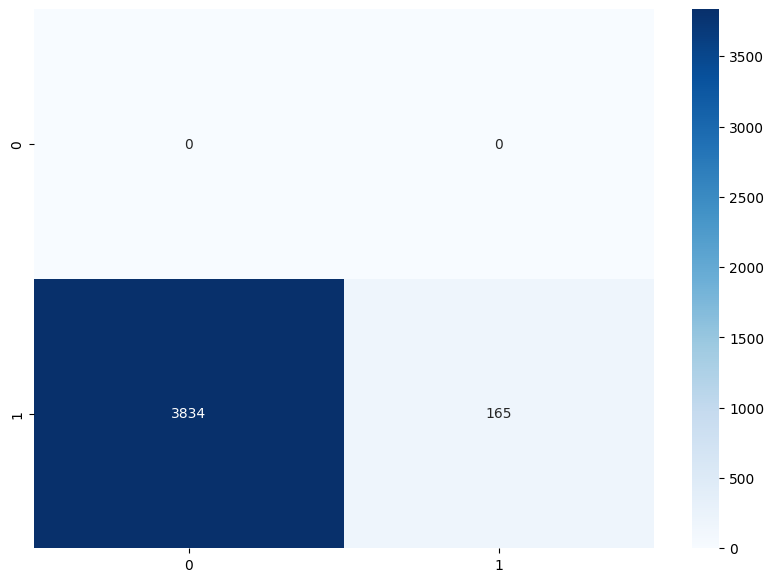

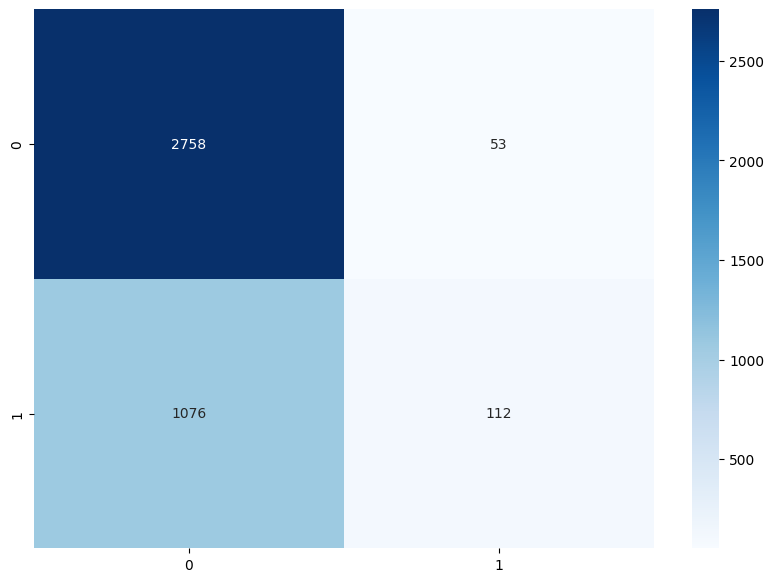

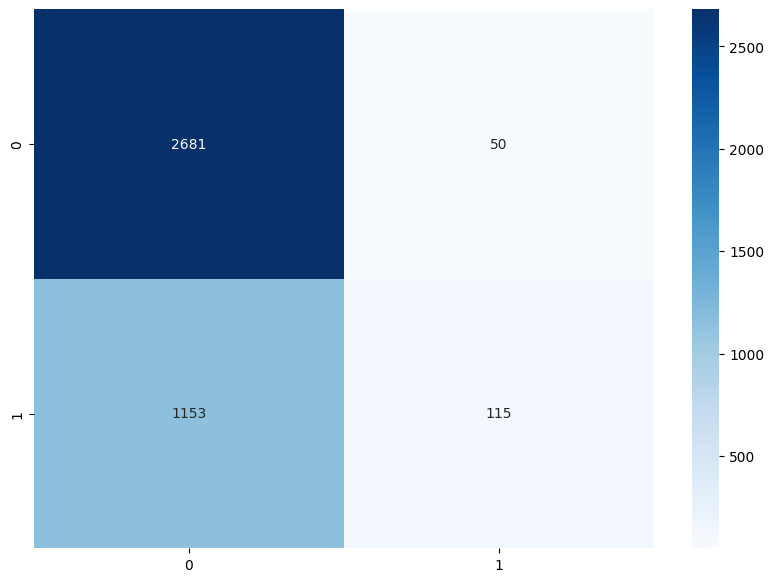

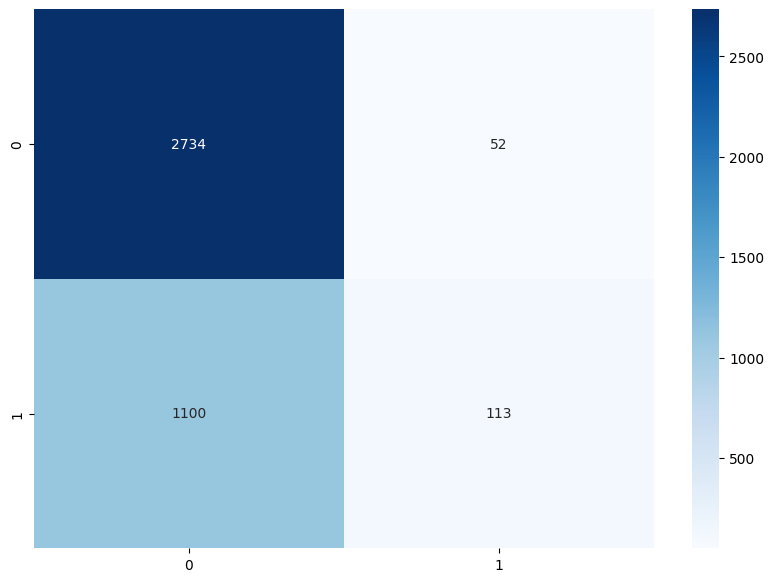

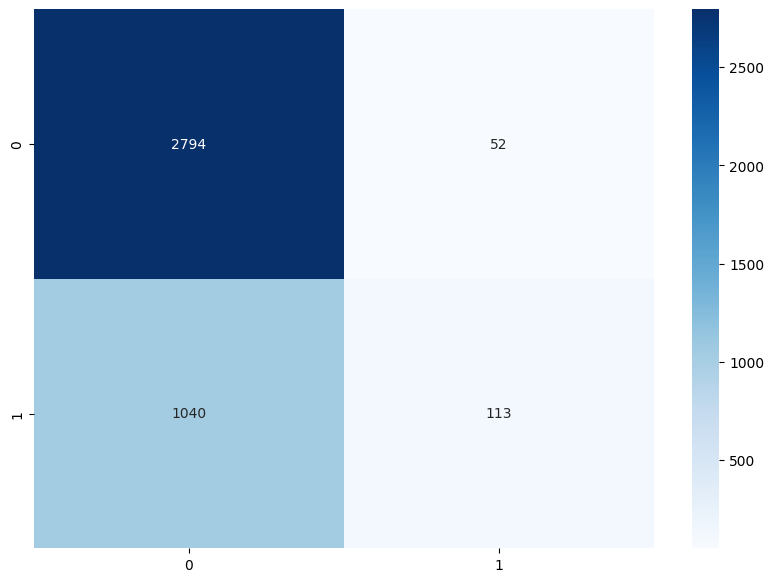

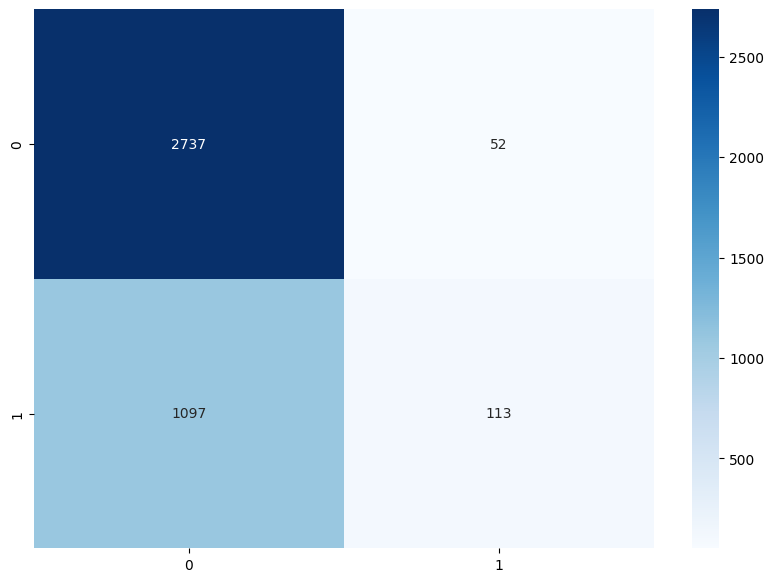

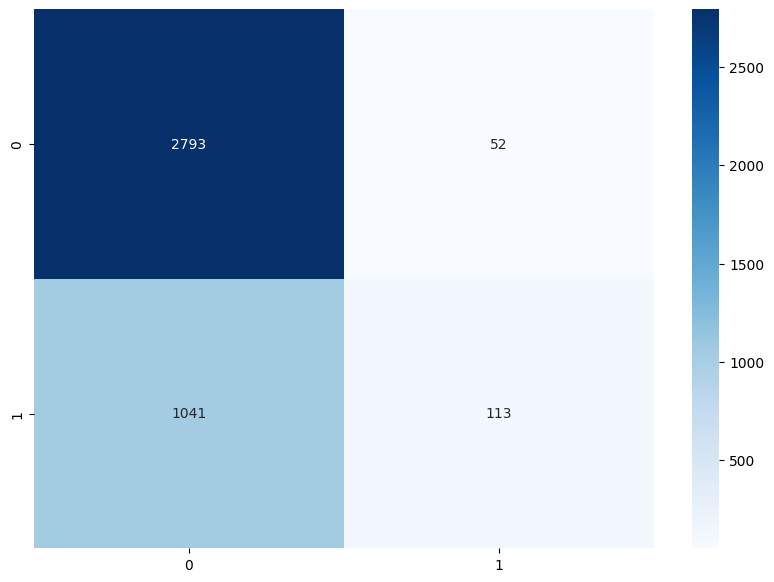

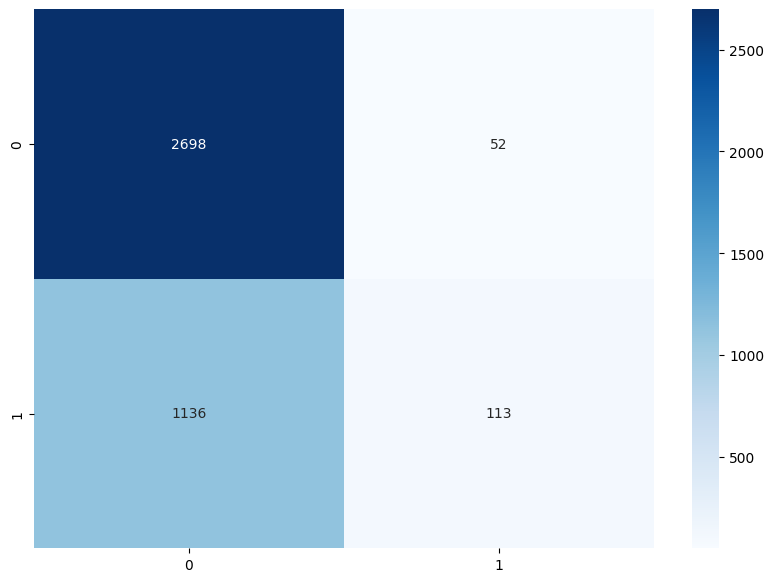

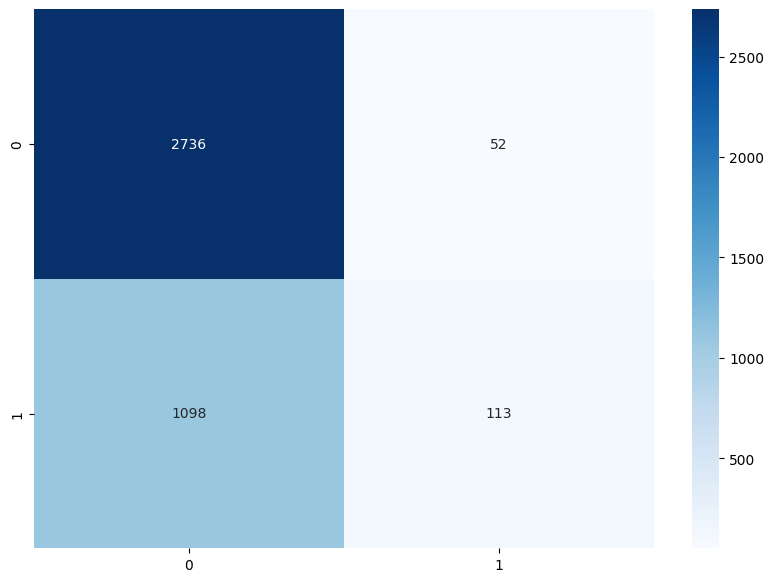

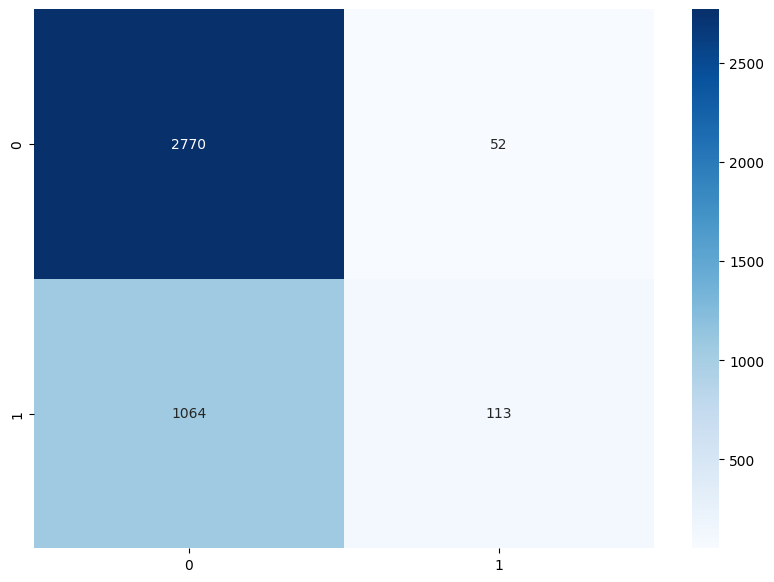

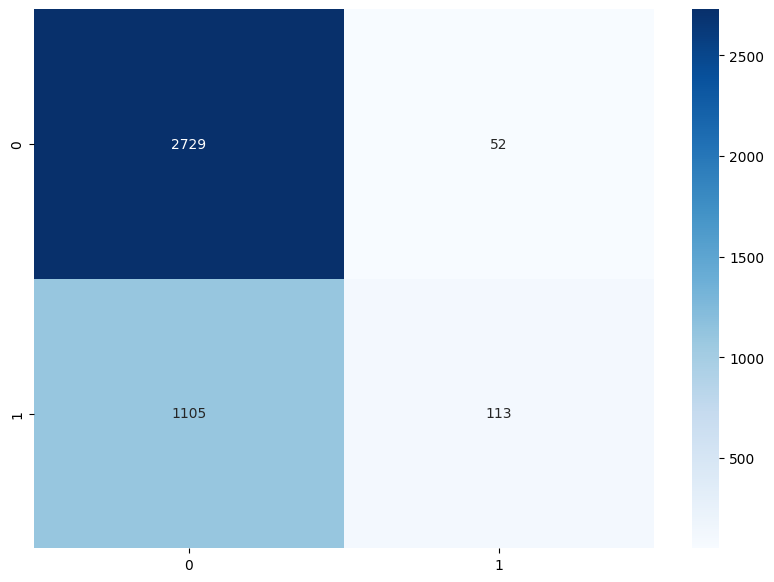

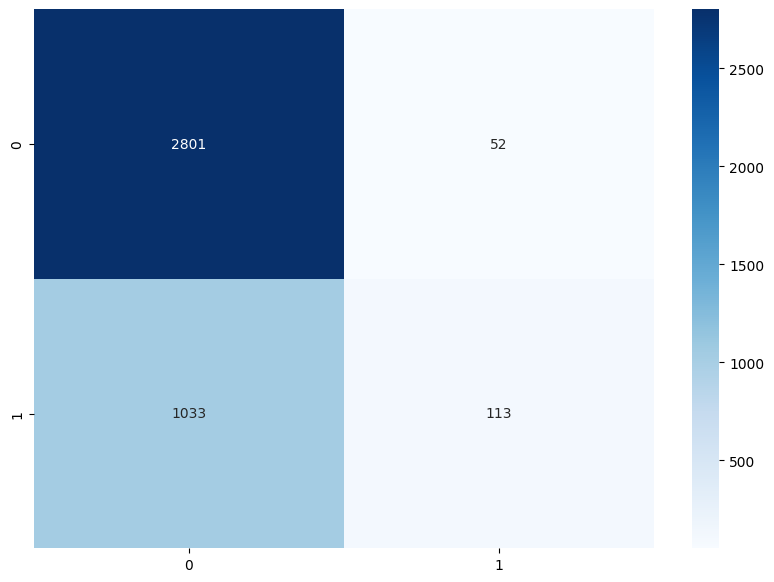

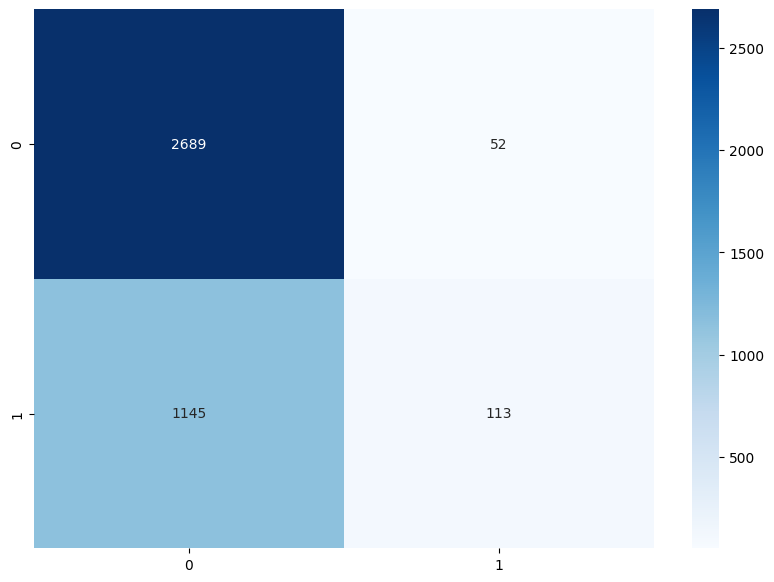

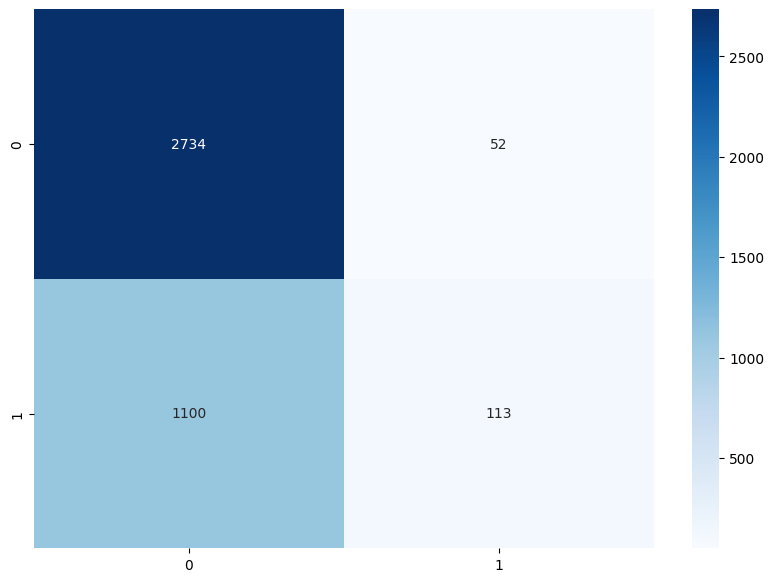

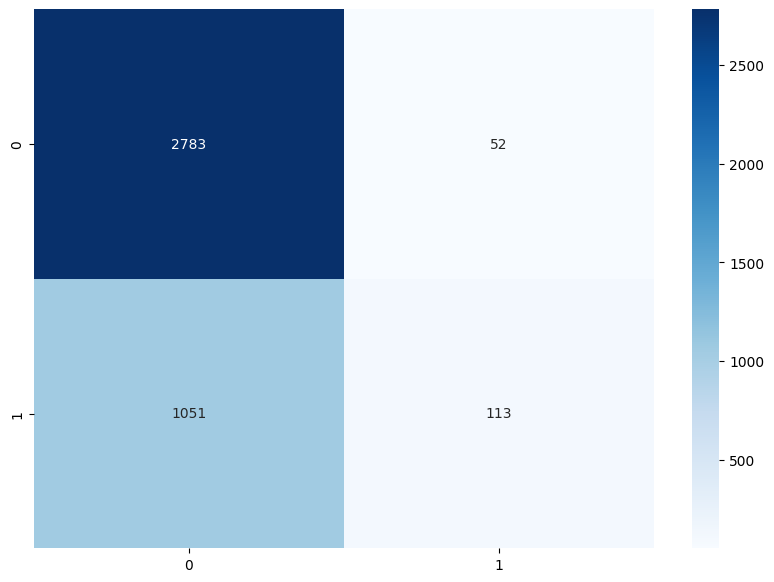

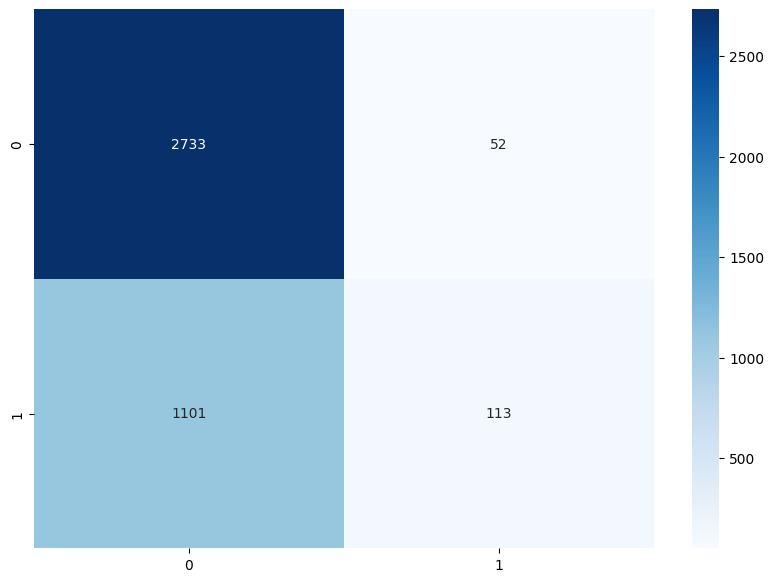

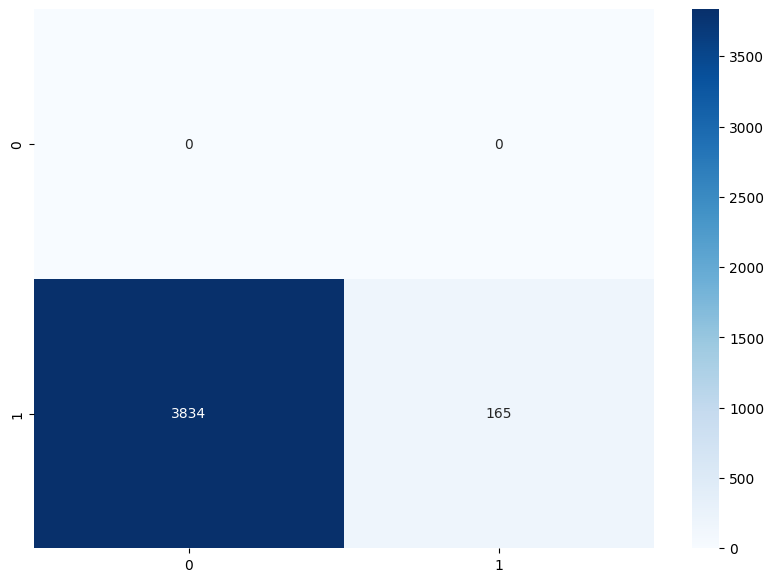

In [43]:
# %% Hyperparameter search
print("Running hyperparameter search...")
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 100

# Initialize and run Tuner
#Tuning using hyperparameters defined above
tuner = Tuner(HYPERPARAMETERS, 
              objective=run_one_training,
              conf_dict=config) 
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best objective:', results['best_objective'])

# See your experiments table inside Colab!
import IPython
display(IPython.display.IFrame("https://dagshub.com/"+ os.environ['MLFLOW_TRACKING_USERNAME'] 
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + "/experiments/#/",'100%',600))

Alternative for MLFlow

In [ ]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")# run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6


# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)

#Best Hyperparameters

In [ ]:
BEST_PARAMETERS = {
    "batch_size": [128],
    "learning_rate": [0.01],
    "weight_decay": [0.0001],
    "sgd_momentum": [0.8],
    "scheduler_gamma": [0.8],
    "pos_weight": [1.3],
    "model_embedding_size": [64],
    "model_attention_heads": [3],
    "model_layers": [4],
    "model_dropout_rate": [0.2],
    "model_top_k_ratio": [0.5],
    "model_top_k_every_n": [1],
    "model_dense_neurons": [256]
}

## Improving the model / More to play around with


For example you can add:
- Dropouts
- Other (more intelligent) Pooling Layers (all layers here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#)
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...

https://github.com/rusty1s/pytorch_geometric/tree/master/examples

#References used for understanding GNNs:


* https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=qoW2Z7P70LNQ
* 	arXiv:1609.02907 [cs.LG]

 	(or arXiv:1609.02907v4 [cs.LG] for this version)

  https://doi.org/10.48550/arXiv.1609.02907

* https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab - For MLflow

* https://distill.pub/2021/gnn-intro/
 
 